# Model Implementation

**Modeling Note**:

Due to capacity and runtime constraints, I have not implemented computationally intensive sampling techniques such as SMOTE or SMOTEENN. Instead, I have opted for simple random undersampling to address class imbalance. While this approach significantly reduces computation time, it may also result in less optimal model performance—especially when detecting the minority class. The results presented herein reflect the trade-off between faster processing and potentially improved predictive performance that might be achievable using more advanced oversampling methods.

## Imports

In [1]:
import pandas as pd
import numpy as np

import joblib
import json

import matplotlib.pyplot as plt
import seaborn as sns

import os
from dotenv import load_dotenv

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, auc, recall_score
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.utils import resample

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
load_dotenv()

data_path = os.getenv('DATA_PATH')

## Data

In [3]:
data = pd.read_csv(os.path.join(data_path, "processed_data.csv"))
data.head()

,step,type,amount,oldbalanceOrig,newbalanceOrig,balanceChangeOrig,OrigEmptyBefore,OrigEmptyAfter,nameDest,oldbalanceDest,newbalanceDest,balanceChangeDest,DestEmptyBefore,DestEmptyAfter,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,9839.64,0,0,M1979787155,0.0,0.0,0.0,1,1,0
1,1,PAYMENT,1864.28,21249.0,19384.72,1864.28,0,0,M2044282225,0.0,0.0,0.0,1,1,0
2,1,TRANSFER,181.00,181.0,0.00,181.00,0,1,C553264065,0.0,0.0,0.0,1,1,1
3,1,CASH_OUT,181.00,181.0,0.00,181.00,0,1,C38997010,21182.0,0.0,21182.0,0,0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,11668.14,0,0,M1230701703,0.0,0.0,0.0,1,1,0


In [4]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   step               int64  
 1   type               object 
 2   amount             float64
 3   oldbalanceOrig     float64
 4   newbalanceOrig     float64
 5   balanceChangeOrig  float64
 6   OrigEmptyBefore    int64  
 7   OrigEmptyAfter     int64  
 8   nameDest           object 
 9   oldbalanceDest     float64
 10  newbalanceDest     float64
 11  balanceChangeDest  float64
 12  DestEmptyBefore    int64  
 13  DestEmptyAfter     int64  
 14  isFraud            int64  
dtypes: float64(7), int64(6), object(2)
memory usage: 728.1+ MB


## Train/ Test Data

In [6]:
X = data.drop(['isFraud'], axis = 1)
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,
                                                    stratify = y)

In [7]:
# Frequency Encoding: Count how often each nameDest account appears in training data

name_counts = X_train['nameDest'].value_counts()
X_train['nameDest_freq'] = X_train['nameDest'].map(name_counts)
X_test['nameDest_freq'] = X_test['nameDest'].map(name_counts).fillna(0)

# Fraud Rate Encoding: Calculate the fraud rate per destination account.

train_data = X_train.copy()
train_data['isFraud'] = y_train
fraud_rate = train_data.groupby('nameDest')['isFraud'].mean()

X_train['nameDest_fraud_rate'] = X_train['nameDest'].map(fraud_rate)
# For Test Data fill missing accounts with global fraud rate from Train Data
global_fraud_rate = y_train.mean()
X_test['nameDest_fraud_rate'] = X_test['nameDest'].map(fraud_rate).fillna(global_fraud_rate)

# Drop 'nameDest' after creating new Features
X_train = X_train.drop(['nameDest'], axis = 1)
X_test = X_test .drop(['nameDest'], axis = 1)

**Explanation**:

Feature Engineering on **'nameDest'**:
- we extract useful information from the 'nameDest' feature:
  1. **Frequency Encoding** (nameDest_freq): this feature captures how many times each destination account appears in the training data. It provides insight into the activity level of the account.
  2. **Fraud Rate Encoding** ('nameDest_fraud_rate'): this feature calculates the proportion of fraudulent transactions associated with each destination account, giving a risk profile for the account.

After generating these features we drop the original 'nameDest' column to reduce noise and avoid overfitting, since the raw account IDs are less informative than the engineered features.

In [8]:
X_train.shape

(4453834, 15)

In [9]:
X_test.shape

(1908786, 15)

In [10]:
y_train.shape

(4453834,)

In [11]:
y_test.shape

(1908786,)

In [12]:
X_train.head()

,step,type,amount,oldbalanceOrig,newbalanceOrig,balanceChangeOrig,OrigEmptyBefore,OrigEmptyAfter,oldbalanceDest,newbalanceDest,balanceChangeDest,DestEmptyBefore,DestEmptyAfter,nameDest_freq,nameDest_fraud_rate
4310249,308,CASH_IN,260485.23,32371.00,292856.23,-260485.23,0,0,4633560.35,4373075.12,260485.23,0,0,21,0.0
318938,16,TRANSFER,1387060.19,432673.78,0.00,432673.78,0,1,0.00,1033440.62,-1033440.62,1,1,15,0.0
3375139,254,TRANSFER,1140661.98,59947.00,0.00,59947.00,0,1,15000.85,1155662.83,-1140661.98,0,0,7,0.0
5492781,380,CASH_IN,169390.39,80047.10,249437.49,-169390.39,0,0,1467039.66,1297649.27,169390.39,0,0,12,0.0
807263,40,CASH_IN,4867.26,5989226.14,5994093.40,-4867.26,0,0,1609385.28,1604518.02,4867.26,0,0,24,0.0


## Endcoding and Scaling

In [13]:
log_features = ['amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 
                'newbalanceDest']


other_num_features = ['step', 'balanceChangeOrig', 'balanceChangeDest', 
                      'nameDest_freq', 'nameDest_fraud_rate']

cat_features = ['type', 'OrigEmptyBefore', 'OrigEmptyAfter', 'DestEmptyBefore', 
                'DestEmptyAfter']

log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

other_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('log_num', log_pipeline, log_features),
    ('other_num', other_pipeline, other_num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

## Implementing Pipelines

In [14]:
# Sampling before

X_train_res, y_train_res = RandomUnderSampler(random_state = 42).fit_resample(X_train, y_train)


### Logistic Regression

In [15]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(class_weight = 'balanced', max_iter = 4000))
])

lr_params = { 
    'clf__C': [0.01, 0.1, 1],
    'clf__penalty': ['l1'],
    'clf__solver': ['saga'],
              }

### Random Forest

In [16]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight = 'balanced', random_state = 42))
])

rf_params = { 
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
}

## GridSearch

### Logistic Regression

In [17]:
grid_lr = GridSearchCV(lr_pipeline, 
                       lr_params, 
                       cv = 3, 
                       scoring = 'recall', 
                       n_jobs = -1 )


grid_lr.fit(X_train_res, y_train_res)

print('Best LogReg Model:', grid_lr.best_estimator_)
print('Best LogReg Parameters:', grid_lr.best_params_)
print('Best CV Score LogReg:', grid_lr.best_score_)

Best LogReg Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount', 'oldbalanceOrig',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('other_num',
                                                  Pipeline(steps=[(

In [18]:
#Save best model

final_lr_model = grid_lr.best_estimator_
joblib.dump(final_lr_model, 'lr_model.pkl')

#Save best params as json

with open('lr_best_params.json', 'w') as f:
    json.dump(grid_lr.best_params_, f)

In [19]:
# Load Params Logistic Regression

model_path = os.path.join("..", "model_config")

lr_pipeline = joblib.load(os.path.join(model_path, 'lr_model.pkl'))

with open(os.path.join(model_path, 'lr_best_params.json'), 'r') as f:
    best_params = json.load(f)

best_C = best_params.get('clf__C', 1)
best_penalty = best_params.get('clf__penalty', 'l1')
best_solver = best_params.get('clf__solver', 'saga')

In [20]:
# Evaluate on Testset before Feature Selection
threshold = 0.3

y_pred_proba = lr_pipeline.predict_proba(X_test)[:,1]
y_pred_lr = (y_pred_proba >= threshold).astype(int)


print("Test Score:", lr_pipeline.score(X_test, y_test))

print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

Test Score: 0.9957679907543329
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906322
           1       0.09      0.44      0.15      2464

    accuracy                           0.99   1908786
   macro avg       0.55      0.72      0.58   1908786
weighted avg       1.00      0.99      1.00   1908786



### Random Forest

In [21]:
grid_rf = GridSearchCV(rf_pipeline, 
                       rf_params, 
                       cv = 3, 
                       scoring = 'recall', 
                       n_jobs = 1)


grid_rf.fit(X_train_res, y_train_res)

print('Best Random Forest Model:', grid_rf.best_estimator_)
print('Best Random Forest Parameters:', grid_rf.best_params_)
print('Best CV Score Random Forest:', grid_rf.best_score_)

Best Random Forest Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount', 'oldbalanceOrig',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('other_num',
                                                  Pipeline(s

In [22]:
# Save best model

final_rf_model = grid_rf.best_estimator_
joblib.dump(final_rf_model, 'rf_model.pkl')

# Save best params as json

with open('rf_best_params.json', 'w') as f:
    json.dump(grid_rf.best_params_, f)

In [23]:
# Load Params Random Forest

rf_pipeline = joblib.load(os.path.join(model_path, 'rf_model.pkl'))

with open(os.path.join(model_path, 'rf_best_params.json'), 'r') as f:
    best_params_rf = json.load(f)

best_max_depth = best_params_rf.get('clf__max_depth', None)
best_estimators = best_params_rf.get('clf__n_estimators', 150)
best_min_samples = best_params_rf.get('clf__min_samples_split', 2)                                   

In [24]:
# Evaluate on Testset before Feature Selection

y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

y_pred_rf = (y_pred_proba_rf >= threshold).astype(int)

print("Test Score:", rf_pipeline.score(X_test, y_test))

print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Test Score: 0.9966958056062859
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.13      0.41      0.20      2464

    accuracy                           1.00   1908786
   macro avg       0.57      0.70      0.60   1908786
weighted avg       1.00      1.00      1.00   1908786



### Feature Importance

#### Random Forest

In [25]:
best_clf_rf = rf_pipeline.named_steps['clf']

rf_preprocessor = rf_pipeline.named_steps['preprocessor']

feature_names = rf_preprocessor.get_feature_names_out()

rf_importances = best_clf_rf.feature_importances_

rf_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importances': rf_importances
}).sort_values(by = 'Importances', ascending = False)

print(rf_importances_df)

                           Feature  Importances
9   other_num__nameDest_fraud_rate     0.412354
6     other_num__balanceChangeOrig     0.146154
1          log_num__oldbalanceOrig     0.091651
0                  log_num__amount     0.054414
2          log_num__newbalanceOrig     0.040424
17           cat__OrigEmptyAfter_0     0.034683
18           cat__OrigEmptyAfter_1     0.029688
15          cat__OrigEmptyBefore_0     0.028009
13               cat__type_PAYMENT     0.027180
16          cat__OrigEmptyBefore_1     0.024467
7     other_num__balanceChangeDest     0.024354
14              cat__type_TRANSFER     0.022640
5                  other_num__step     0.013245
10               cat__type_CASH_IN     0.012260
3          log_num__oldbalanceDest     0.009257
4          log_num__newbalanceDest     0.008673
11              cat__type_CASH_OUT     0.006001
19          cat__DestEmptyBefore_0     0.004560
21           cat__DestEmptyAfter_0     0.002795
8         other_num__nameDest_freq     0

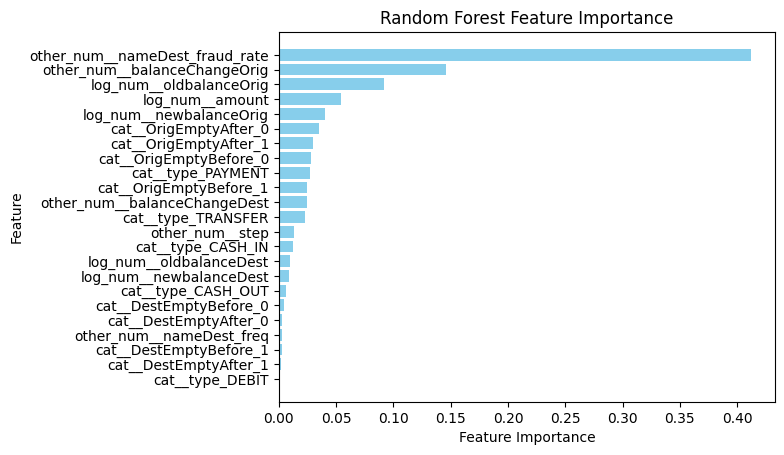

In [26]:
plt.barh(rf_importances_df['Feature'], rf_importances_df['Importances'], color = 'skyblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

#### Logistic Regression

In [27]:
best_clf_lr = lr_pipeline.named_steps['clf']

lr_preprocessor = lr_pipeline.named_steps['preprocessor']

feature_names_lr = lr_preprocessor.get_feature_names_out()

lr_coefs = best_clf_lr.coef_[0]

lr_coef_df = pd.DataFrame({
    'Feature': feature_names_lr,
    'Coefficient': lr_coefs,
    'Abs Coefficient': abs(lr_coefs)
}).sort_values(by = 'Abs Coefficient', ascending = False)

print(lr_coef_df)

                           Feature  Coefficient  Abs Coefficient
9   other_num__nameDest_fraud_rate    27.451216        27.451216
6     other_num__balanceChangeOrig     8.433011         8.433011
11              cat__type_CASH_OUT     5.880748         5.880748
14              cat__type_TRANSFER     4.970046         4.970046
18           cat__OrigEmptyAfter_1     3.674609         3.674609
16          cat__OrigEmptyBefore_1     3.641806         3.641806
1          log_num__oldbalanceOrig     3.081986         3.081986
2          log_num__newbalanceOrig    -2.540314         2.540314
0                  log_num__amount    -1.401220         1.401220
8         other_num__nameDest_freq     1.245744         1.245744
4          log_num__newbalanceDest    -1.064358         1.064358
10               cat__type_CASH_IN    -0.205125         0.205125
3          log_num__oldbalanceDest    -0.137746         0.137746
12                 cat__type_DEBIT    -0.065372         0.065372
5                  other_

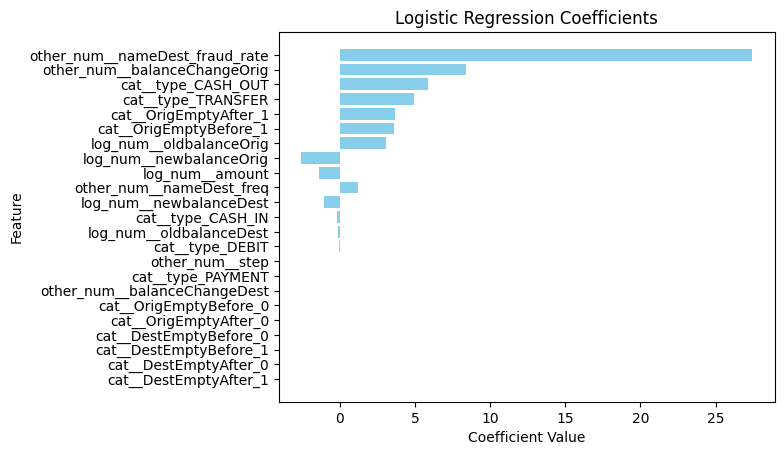

In [28]:
plt.barh(lr_coef_df['Feature'], lr_coef_df['Coefficient'], color = 'skyblue')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

**Analysis of Feature Importances**: 

**Random Forest**:

The feature **nameDest_fraud_rate** clearly dominates the Random Forest model, contributing over 41 % to the total feature importance. This confirms that the historical fraud rate of a destination account is a very strong indicator for predicting fraudulent behavior.

Other notable features include:

- **balanceChangeOrig** (14.6%): The net change in the sender’s balance is a strong signal.

- **oldbalanceOrig** (9.1%) and amount (5.4%): These features also play significant roles in model decisions.

- **newbalanceOrig** (4.0%) follows closely in importance.

Features with higher importance scores are used more frequently for decision splits in the Random Forest, indicating they are critical for classification accuracy.

Interestingly, several categorical features, such as **OrigEmptyAfter_0/1**, **OrigEmptyBefore_0/1**, and transaction types like **type_PAYMENT** or **type_TRANSFER**, also contribute meaningfully, each scoring between 2% and 3%.

**Logistic Regression**:

In Logistic Regression, the magnitude and sign of the coefficients determine the influence of each feature on the prediction:

- The feature **nameDest_fraud_rate** again dominates with an exceptionally large positive coefficient (+27.45), strongly increasing the predicted probability of fraud.

- **balanceChangeOrig** (+8.43), **oldbalanceOrig** (+3.08), and **nameDest_freq** (+1.24) also show high positive influence.

- **CASH_OUT** and **TRANSFER** transaction types also have strong positive coefficients, aligning with common fraud patterns in these categories.

In summary:

- A positive coefficient increases the log-odds (and thus probability) of predicting fraud.

- A negative coefficient decreases the log-odds of fraud.

- The absolute value reflects the strength of the influence: The larger the absolute value, the greater the impact on the predicted probability, even with small changes in the feature’s value.

It is worth noting that many categorical features (e.g., transaction types and balance indicators) have a coefficient of zero in this model, meaning they were either not influential or removed during regularization.

## Model Training with selected Features

Select the important Features from the Models via a threshhold.

In [29]:
from sklearn.feature_selection import SelectFromModel

### Logistic Regression

In [30]:
threshold_fs_lr = 0.01

lr_selector = SelectFromModel(best_clf_lr, threshold = threshold_fs_lr, prefit = True)

In [31]:
pipeline_lr_fs = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', lr_selector),
    ('clf', LogisticRegression(C=best_C, penalty=best_penalty, solver=best_solver,
                               class_weight='balanced', max_iter=4000))
])

pipeline_lr_fs.fit(X_train_res, y_train_res)

print("Logistic Regression Test Score (with Feature Selection):", pipeline_lr_fs.score(X_test, y_test))

Logistic Regression Test Score (with Feature Selection): 0.9957617040359684


#### Metrics Logistic Regression

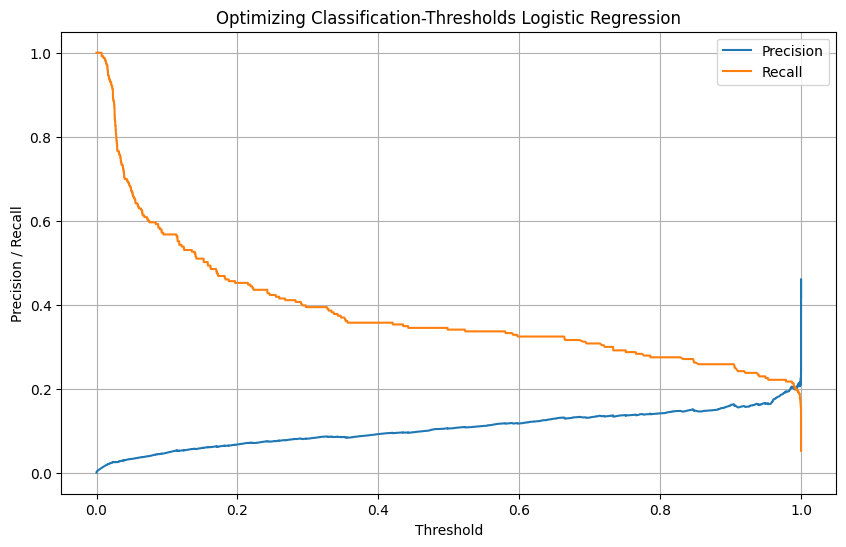

In [32]:
# Precision - Recall

y_pred_proba_lr = pipeline_lr_fs.predict_proba(X_test)[:, 1]

y_test_sampled_lr, y_pred_proba_sampled_lr = resample(y_test, y_pred_proba_lr, 
                                                      n_samples=int(len(y_test) * 0.1), random_state=42)

precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test_sampled_lr, y_pred_proba_sampled_lr)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_lr, precision_lr[:-1], label='Precision')
plt.plot(thresholds_lr, recall_lr[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Optimizing Classification-Thresholds Logistic Regression')
plt.legend()
plt.grid()
plt.show()


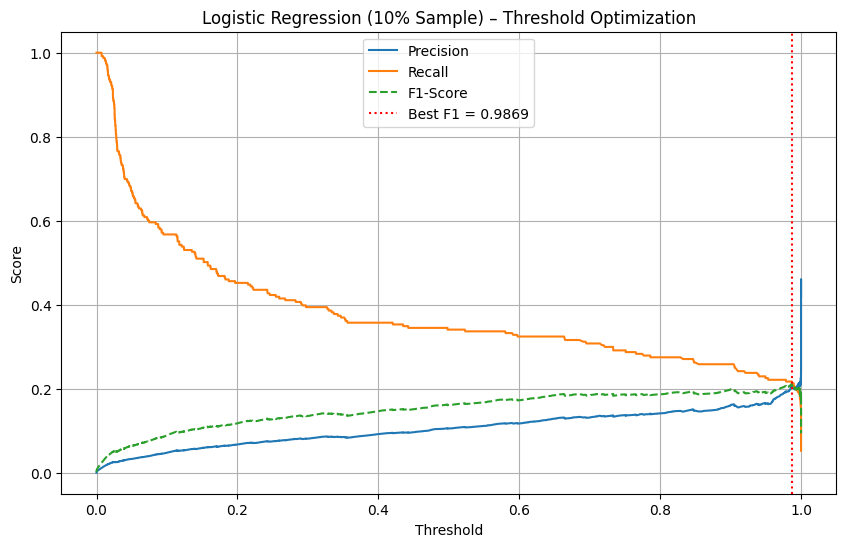

Logistic Regression – Optimal F1-Threshold: 0.9869 (F1 = 0.2120)


In [94]:
# F1 Score 

precision_lr_reduced = precision_lr[:-1]
recall_lr_reduced = recall_lr[:-1]

f1_scores_lr = [
    f1_score(y_test_sampled_lr, (y_pred_proba_sampled_lr >= t).astype(int)) 
    for t in thresholds_lr
]

best_idx_lr = np.argmax(f1_scores_lr)
best_threshold_lr = thresholds_lr[best_idx_lr]
best_f1_lr = f1_scores_lr[best_idx_lr]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_lr, precision_lr_reduced, label='Precision')
plt.plot(thresholds_lr, recall_lr_reduced, label='Recall')
plt.plot(thresholds_lr, f1_scores_lr, label='F1-Score', linestyle='--')
plt.axvline(x=best_threshold_lr, color='r', linestyle=':', label=f'Best F1 = {best_threshold_lr:.4f}')
plt.title('Logistic Regression (10% Sample) – Threshold Optimization')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

print(f"Logistic Regression – Optimal F1-Threshold: {best_threshold_lr:.4f} (F1 = {best_f1_lr:.4f})")


In [95]:
y_pred_lr = (y_pred_proba_lr >= best_threshold_lr).astype(int)

print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.23      0.25      0.23      2464

    accuracy                           1.00   1908786
   macro avg       0.61      0.62      0.62   1908786
weighted avg       1.00      1.00      1.00   1908786



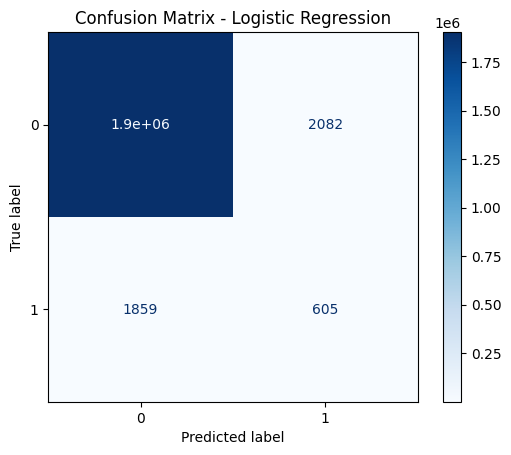

In [80]:
# Confusion Matrix

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Random Forest

In [33]:
threshold_fs_rf = 0.01

rf_selector = SelectFromModel(best_clf_rf, threshold = threshold_fs_rf, prefit = True)

In [34]:
pipeline_rf_fs = ImbPipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', rf_selector),
    ('clf', RandomForestClassifier(n_estimators = best_estimators, max_depth = best_max_depth,
                                   min_samples_split = best_min_samples,
                                   class_weight = 'balanced', random_state = 42))
])

pipeline_rf_fs.fit(X_train, y_train)

print("Random Forest Test Score (with Feature Selection):", pipeline_rf_fs.score(X_test, y_test))

Random Forest Test Score (with Feature Selection): 0.9987007448713475


#### Metrics Random Forest

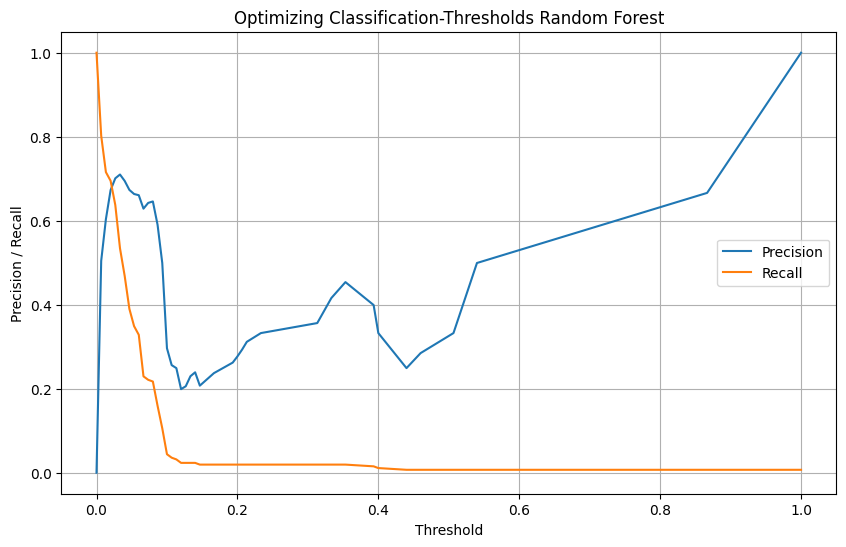

In [35]:
# Precision - Recall 

y_pred_proba_rf = pipeline_rf_fs.predict_proba(X_test)[:, 1]

sample_size = int(len(y_test) * 0.1)

y_test_sampled_rf, y_pred_proba_sampled_rf = resample(y_test, y_pred_proba_rf, 
                                                      n_samples=int(len(y_test) * 0.1), random_state=42)

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test_sampled_rf, y_pred_proba_sampled_rf)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_rf, precision_rf[:-1], label='Precision')
plt.plot(thresholds_rf, recall_rf[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Optimizing Classification-Thresholds Random Forest')
plt.legend()
plt.grid()
plt.show()

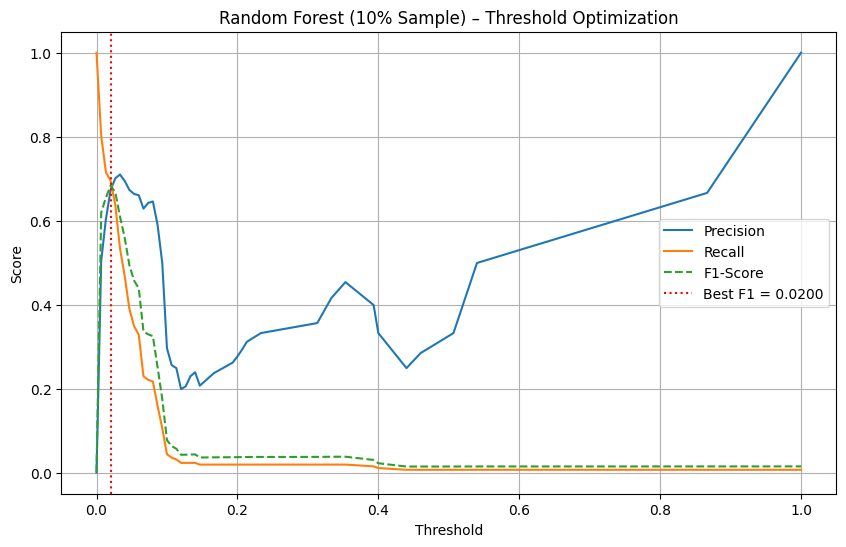

Best F1-Threshold: 0.0200  (F1-Score = 0.6842)


In [86]:
# F1 Score

precision_rf_reduced = precision_rf[:-1]
recall_rf_reduced = recall_rf[:-1]


f1_scores_rf = [
    f1_score(y_test_sampled_rf, (y_pred_proba_sampled_rf >= t).astype(int))
    for t in thresholds_rf
]

best_idx_rf = np.argmax(f1_scores_rf)
best_threshold_rf = thresholds_rf[best_idx_rf]
best_f1_rf = f1_scores_rf[best_idx_rf]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds_rf, precision_rf_reduced, label='Precision')
plt.plot(thresholds_rf, recall_rf_reduced, label='Recall')
plt.plot(thresholds_rf, f1_scores_rf, label='F1-Score', linestyle='--')
plt.axvline(x=best_threshold_rf, color='r', linestyle=':', label=f'Best F1 = {best_threshold_rf:.4f}')
plt.title('Random Forest (10% Sample) – Threshold Optimization')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

print(f"Random Forest – Optimal F1-Threshold: {best_threshold_rf:.4f}  (F1-Score = {best_f1_rf:.4f})")

In [87]:
y_pred_rf = (y_pred_proba_rf >= best_threshold_rf).astype(int)

print('Classification Report - Random Forest:')
print(classification_report(y_test, y_pred_rf))

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.69      0.73      0.71      2464

    accuracy                           1.00   1908786
   macro avg       0.85      0.86      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786



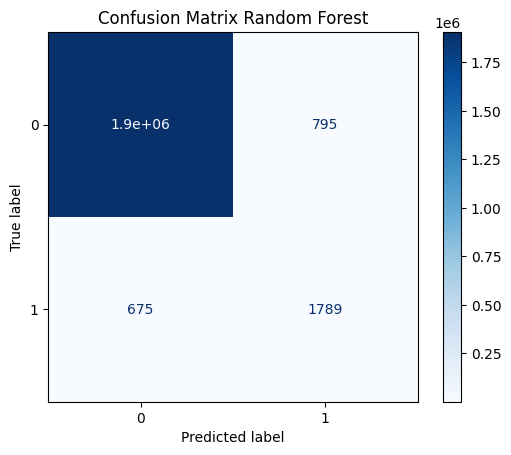

In [88]:
# Confusion Matrix

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap=plt.cm.Blues)
plt.title("Confusion Matrix Random Forest")
plt.show()

In [96]:
# Save final Model with threshold

joblib.dump({
    "model": pipeline_rf_fs,
    "threshold": best_threshold_rf
}, "rf_model_bundle.pkl")

['rf_model_bundle.pkl']

## XGBoost

In [36]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print('scale_pos_weight:', scale_pos_weight)

scale_pos_weight: 773.7145590537485


In [37]:
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric = 'logloss',
                          scale_pos_weight = scale_pos_weight,
                          random_state = 42))
])

In [38]:
params_xgb = {
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__n_estimators': [50, 100, 200]
}

In [39]:
grid_xgb = GridSearchCV(pipeline_xgb, 
                        params_xgb, 
                        cv = 5, 
                        scoring = 'recall', 
                        n_jobs = 1, 
                        verbose = 1)
 

grid_xgb.fit(X_train_res, y_train_res)
                      
print('Best XGBoost Model:', grid_xgb.best_estimator_)
print('Best XGBoostt Parameters:', grid_xgb.best_params_)
print('Best CV Score XGBoost:', grid_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best XGBoost Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount', 'oldbalanceOrig',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('other_num',
    

In [40]:
# Save best model

final_xgb_model = grid_xgb.best_estimator_
joblib.dump(final_xgb_model, 'xgb_model.pkl')

# Save best params as json

with open('xgb_best_params.json', 'w') as f:
     json.dump(grid_xgb.best_params_, f)

In [41]:
# Load Params XGBoost

xgb_pipeline = joblib.load(os.path.join(model_path, 'XGB_model.pkl'))

with open(os.path.join(model_path, 'xgb_best_params.json'), 'r') as f:
    best_params_xgb = json.load(f)

best_subsample = best_params_xgb.get('clf__subsample', 0.6)
best_max_depth = best_params_xgb.get('clf__max_depth', 3)
best_learning_rate = best_params_xgb.get('clf__learning_rate', 0.01)
best_estimators = best_params_xgb.get('clf__n_estimators', 50)

In [42]:
# Evaluate on Testset

xgb_pipeline.fit(X_train_res, y_train_res)

y_pred_xgb = xgb_pipeline.predict(X_test)

print("Test Score:", xgb_pipeline.score(X_test, y_test))

Test Score: 0.001290872837499856


In [45]:
# Evaluation before Feature Selection

y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

y_pred_xgb = (y_proba_xgb >= 0.3).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Classification Report:


C:\Users\adris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00   1906322
           1       0.00      1.00      0.00      2464

    accuracy                           0.00   1908786
   macro avg       0.00      0.50      0.00   1908786
weighted avg       0.00      0.00      0.00   1908786



C:\Users\adris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Feature Importance XGBoost

In [44]:
best_clf = xgb_pipeline.named_steps['clf']

xgb_preprocessor = xgb_pipeline.named_steps['preprocessor']

feature_names_xgb = xgb_preprocessor.get_feature_names_out()

xgb_importances = best_clf.feature_importances_

xgb_importances_df = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importances': xgb_importances
}).sort_values(by = 'Importances', ascending = False)

print(xgb_importances_df)

                           Feature  Importances
9   other_num__nameDest_fraud_rate     0.997009
6     other_num__balanceChangeOrig     0.002991
1          log_num__oldbalanceOrig     0.000000
2          log_num__newbalanceOrig     0.000000
3          log_num__oldbalanceDest     0.000000
4          log_num__newbalanceDest     0.000000
0                  log_num__amount     0.000000
5                  other_num__step     0.000000
7     other_num__balanceChangeDest     0.000000
8         other_num__nameDest_freq     0.000000
10               cat__type_CASH_IN     0.000000
11              cat__type_CASH_OUT     0.000000
12                 cat__type_DEBIT     0.000000
13               cat__type_PAYMENT     0.000000
14              cat__type_TRANSFER     0.000000
15          cat__OrigEmptyBefore_0     0.000000
16          cat__OrigEmptyBefore_1     0.000000
17           cat__OrigEmptyAfter_0     0.000000
18           cat__OrigEmptyAfter_1     0.000000
19          cat__DestEmptyBefore_0     0

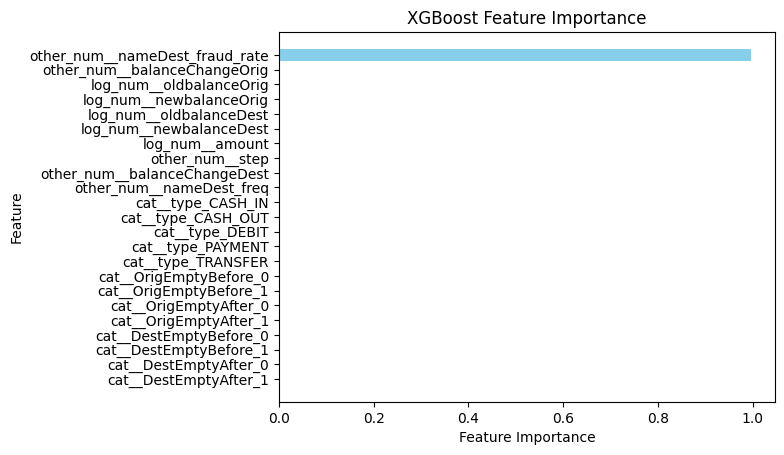

In [46]:
plt.barh(xgb_importances_df['Feature'], xgb_importances_df['Importances'], color = 'skyblue')
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

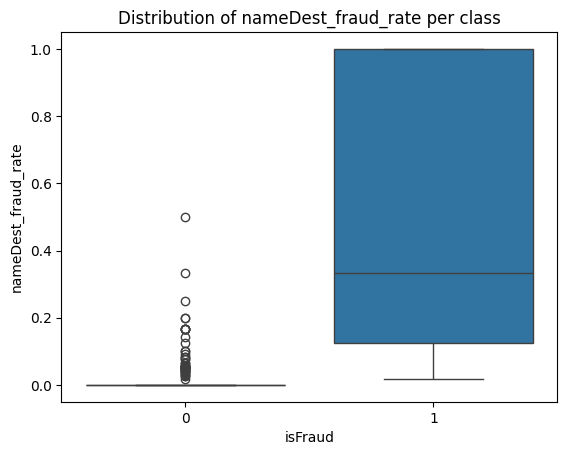

In [47]:
sns.boxplot(x=y_train_res, y=X_train_res['nameDest_fraud_rate'])
plt.title('Distribution of nameDest_fraud_rate per class')
plt.show()

### Model Training with selected Features

In [48]:
xgb_selector = SelectFromModel(best_clf, threshold = 0.001, prefit = True)

In [50]:
pipeline_xgb_fs = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', xgb_selector),
    ('clf', XGBClassifier(subsample = best_subsample, 
                          n_estimators = best_estimators, 
                          max_depth = best_max_depth, 
                          learning_rate = best_learning_rate, 
                          eval_metric = 'logloss',
                          scale_pos_weight=scale_pos_weight,
                          random_state = 42))
])

pipeline_xgb_fs.fit(X_train_res, y_train_res)

print("XGB Test Score (with Feature Selection):", pipeline_xgb_fs.score(X_test, y_test))

XGB Test Score (with Feature Selection): 0.001290872837499856


### Metrics

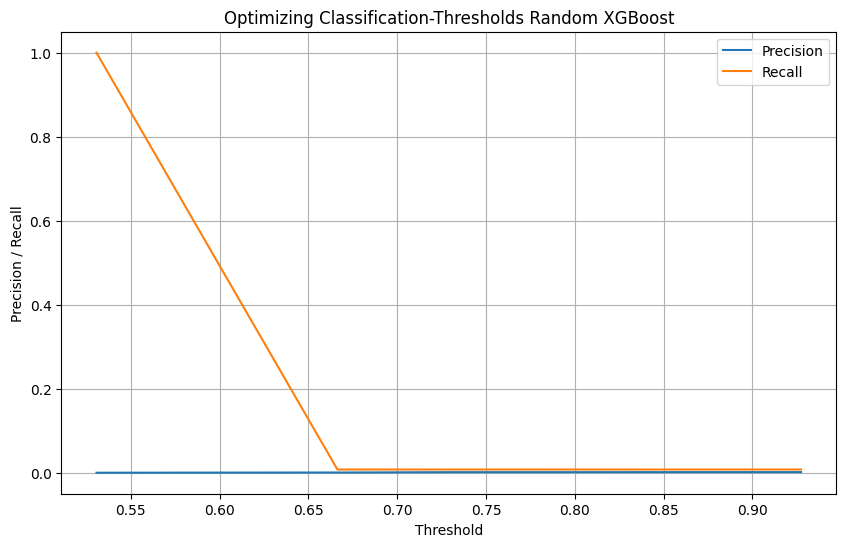

In [74]:
# Precision Recall XGBoost

y_proba_xgb = pipeline_xgb_fs.predict_proba(X_test)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Optimizing Classification-Thresholds Random XGBoost')
plt.legend()
plt.grid()
plt.show()

Best F1-Threshold (sampled): 0.9274 | F1 = 0.0042


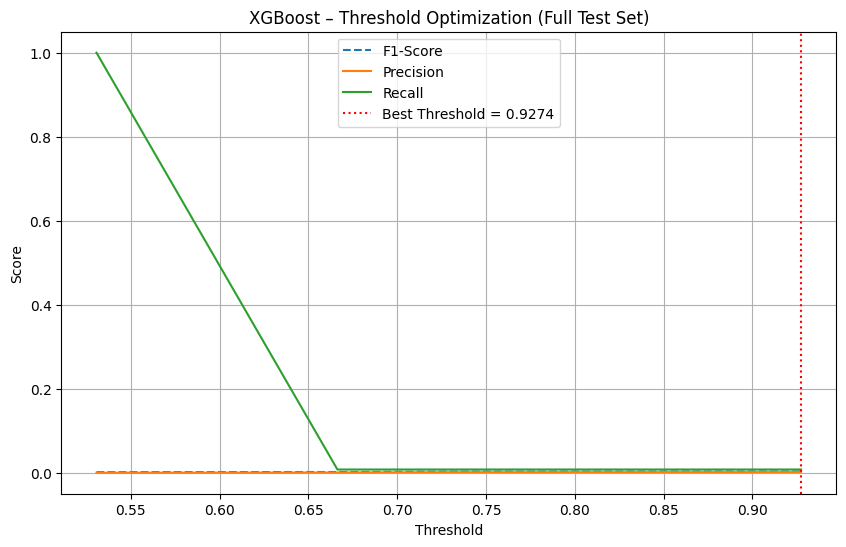

In [89]:
# F1 Score 

precision = precision[:-1]
recall = recall[:-1]

f1_scores = [
    f1_score(y_test, (y_proba_xgb >= t).astype(int)) 
    for t in thresholds
]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score', linestyle='--')
plt.axvline(x=best_threshold, color='r', linestyle=':', label=f'Best F1 = {best_threshold:.4f}')
plt.title('XGBoost – Threshold Optimization (Full Test Set)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

print(f"XGBoost – Optimal F1-Threshold: {best_threshold:.4f}  (F1 = {best_f1:.4f})")


In [91]:
y_pred_xgb = (y_proba_xgb >= best_threshold).astype(int)

print("Classification Report (XGBoost, F1-Optimized Threshold):")
print(classification_report(y_test, y_pred_xgb))

Classification Report (XGBoost, F1-Optimized Threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.00      0.01      0.00      2464

    accuracy                           0.99   1908786
   macro avg       0.50      0.50      0.50   1908786
weighted avg       1.00      0.99      1.00   1908786



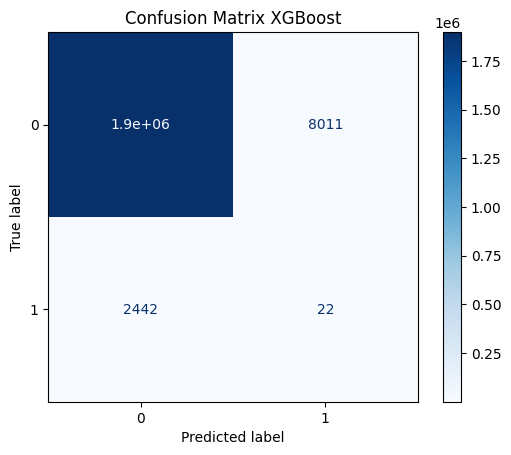

In [92]:
# Confusion Matrix 

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap=plt.cm.Blues)
plt.title("Confusion Matrix XGBoost")
plt.show()

# Model Comparison & Conclusion

This project evaluated three supervised models for fraud detection on a highly imbalanced dataset: Logistic Regression, Random Forest, and XGBoost. Each model underwent threshold optimization based on the F1-Score to better capture the minority (fraud) class. Below is a comparison of their final performance:

**Key Takeaways:**

- **Random Forest** achieved the best overall performance, with the highest F1 and Recall, making it the most effective model for identifying fraud.
- **Logistic Regression** performed solidly and is still useful for interpretability and deployment speed.
- **XGBoost** showed high precision but low recall, likely due to over-penalizing positive predictions with an overly conservative threshold.

Each model benefits from optimized thresholds rather than default 0.5, which improved their fraud detection capability substantially.

For future work, combining these models (stacking/ensembling), incorporating time-series validation, or replacing engineered features like `nameDest_fraud_rate` with leakage-safe alternatives would further enhance robustness.

# Final Reflections and Limitations

This project aimed to build effective fraud detection models using a highly imbalanced dataset. Several techniques such as feature engineering, preprocessing pipelines, undersampling, and threshold optimization were applied to maximize predictive performance. However, a few limitations and reflections should be noted:

## Dominance of Engineered Features:

The feature nameDest_fraud_rate, introduced through domain-driven feature engineering, consistently emerged as the most dominant predictor—especially in tree-based models like Random Forest and XGBoost. While effective, it may introduce potential data leakage, as it summarizes historical fraud outcomes. Therefore, future iterations should evaluate this feature’s robustness using time-aware or leakage-resistant strategies.

## Handling Imbalanced Data:

To reduce runtime complexity, I used RandomUnderSampler instead of more advanced techniques like SMOTE or ensemble-based resampling. This resulted in faster training but may compromise generalizability and minority class recall. A hybrid strategy or cost-sensitive learning could improve performance further.

## Threshold Optimization for F1-Score:

Since the minority class (fraud) is of primary interest, threshold tuning was used to maximize the F1-Score instead of relying on default probability cutoffs. This ensures better balance between precision and recall.

## XGBoost Model Observations:

The XGBoost model performed extremely fast compared to others. I therefore used the full test set for threshold tuning without additional sampling. It’s worth noting that its feature importances were heavily skewed towards nameDest_fraud_rate, raising concerns about model over-reliance on a single feature.

## Computational Trade-Offs:

Several modeling decisions—e.g., undersampling, minimal pipeline nesting, and direct use of fitted estimators for feature selection—were chosen to balance performance with execution time. While this speeds up experimentation, it may reduce robustness in production environments.